In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'SEK=X'
numbers_in_currency = 'SEK'
share_name = 'PDX.ST'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2015-03-31,205,-87,118,76,25,170,0,231,0,...,11,0,0,138,0,144,28,-25,105.6,2015-05-05
1,2015-06-30,182,-74,108,53,147,69,0,260,0,...,7,0,0,144,0,150,175,-21,105.6,2015-08-04
2,2015-09-30,91,-39,51,25,161,24,0,228,0,...,5,0,0,115,0,121,54,-36,105.6,2015-11-04
3,2015-12-31,127,-63,64,35,50,49,0,226,0,...,17,0,0,108,0,139,38,-69,105.6,2016-02-24
4,2016-03-31,93,-42,52,19,57,18,0,142,0,...,6,0,0,77,0,107,32,-15,105.6,2016-05-05


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
31,2022-12-31,2023-02-24,105.619,580,-253,327,194,748,260,0,...,1810,3141,52,0,36,607,0,849,344,-252
32,2023-03-31,2023-05-05,105.799,483,-253,229,124,813,189,0,...,1837,3214,53,0,37,563,0,792,245,-170
33,2023-06-30,2023-08-04,105.799,737,-338,400,239,844,236,0,...,1890,3328,67,0,37,652,0,868,422,-226
34,2023-09-30,2023-11-04,105.799,426,-255,172,69,735,219,0,...,1913,3434,74,0,33,695,0,905,260,-161
35,2023-12-31,2024-02-24,105.799,996,-536,459,98,1098,358,0,...,1569,3580,52,0,33,740,0,960,526,-149


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
31,2022-12-31,2023-02-24,105.619,580,-253,327,194,748,260,0,...,3141,52,0,36,607,0,849,344,-252,10.721097
32,2023-03-31,2023-05-05,105.799,483,-253,229,124,813,189,0,...,3214,53,0,37,563,0,792,245,-170,10.432528
33,2023-06-30,2023-08-04,105.799,737,-338,400,239,844,236,0,...,3328,67,0,37,652,0,868,422,-226,10.518236
34,2023-09-30,2023-11-04,105.799,426,-255,172,69,735,219,0,...,3434,74,0,33,695,0,905,260,-161,10.805716
35,2023-12-31,2024-02-24,105.799,996,-536,459,98,1098,358,0,...,3580,52,0,33,740,0,960,526,-149,10.657495


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
31,2022-12-31,2023-02-24,105.619,580,-253,327,194,748,260,0,...,3141,52,0,36,607,0,849,344,-252,10.721097
32,2023-03-31,2023-05-05,105.799,483,-253,229,124,813,189,0,...,3214,53,0,37,563,0,792,245,-170,10.432528
33,2023-06-30,2023-08-04,105.799,737,-338,400,239,844,236,0,...,3328,67,0,37,652,0,868,422,-226,10.518236
34,2023-09-30,2023-11-04,105.799,426,-255,172,69,735,219,0,...,3434,74,0,33,695,0,905,260,-161,10.805716
35,2023-12-31,2024-02-24,105.799,996,-536,459,98,1098,358,0,...,3580,52,0,33,740,0,960,526,-149,10.657495


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2016-05-30,52.471897,2016-03-31,93,1.25,2.073864,105.6,167.0,1.581439,57,...,0.671779,0.328221,27.388889,36.333333,8.649123,inf,0.55914,0.204301,0.404908,0.60274
1,2016-06-06,47.465408,2016-03-31,93,1.25,2.073864,105.6,167.0,1.581439,57,...,0.671779,0.328221,27.388889,36.333333,8.649123,inf,0.55914,0.204301,0.404908,0.60274
2,2016-06-13,43.325428,2016-03-31,93,1.25,2.073864,105.6,167.0,1.581439,57,...,0.671779,0.328221,27.388889,36.333333,8.649123,inf,0.55914,0.204301,0.404908,0.60274
3,2016-06-20,50.546326,2016-03-31,93,1.25,2.073864,105.6,167.0,1.581439,57,...,0.671779,0.328221,27.388889,36.333333,8.649123,inf,0.55914,0.204301,0.404908,0.60274
4,2016-06-27,49.824234,2016-03-31,93,1.25,2.073864,105.6,167.0,1.581439,57,...,0.671779,0.328221,27.388889,36.333333,8.649123,inf,0.55914,0.204301,0.404908,0.60274


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2016-05-30,52.471897,2016-03-31,93,1.25,2.073864,105.6,167.0,1.581439,57,...,inf,0.55914,0.204301,0.404908,0.60274,41.977518,25.301518,14.895248,15.029657,33.179834
1,2016-06-06,47.465408,2016-03-31,93,1.25,2.073864,105.6,167.0,1.581439,57,...,inf,0.55914,0.204301,0.404908,0.60274,37.972327,22.887430,13.474051,13.608460,30.014055
2,2016-06-13,43.325428,2016-03-31,93,1.25,2.073864,105.6,167.0,1.581439,57,...,inf,0.55914,0.204301,0.404908,0.60274,34.660342,20.891165,12.298831,12.433240,27.396199
3,2016-06-20,50.546326,2016-03-31,93,1.25,2.073864,105.6,167.0,1.581439,57,...,inf,0.55914,0.204301,0.404908,0.60274,40.437061,24.373023,14.348634,14.483043,31.962227
4,2016-06-27,49.824234,2016-03-31,93,1.25,2.073864,105.6,167.0,1.581439,57,...,inf,0.55914,0.204301,0.404908,0.60274,39.859387,24.024836,14.143654,14.278062,31.505623


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

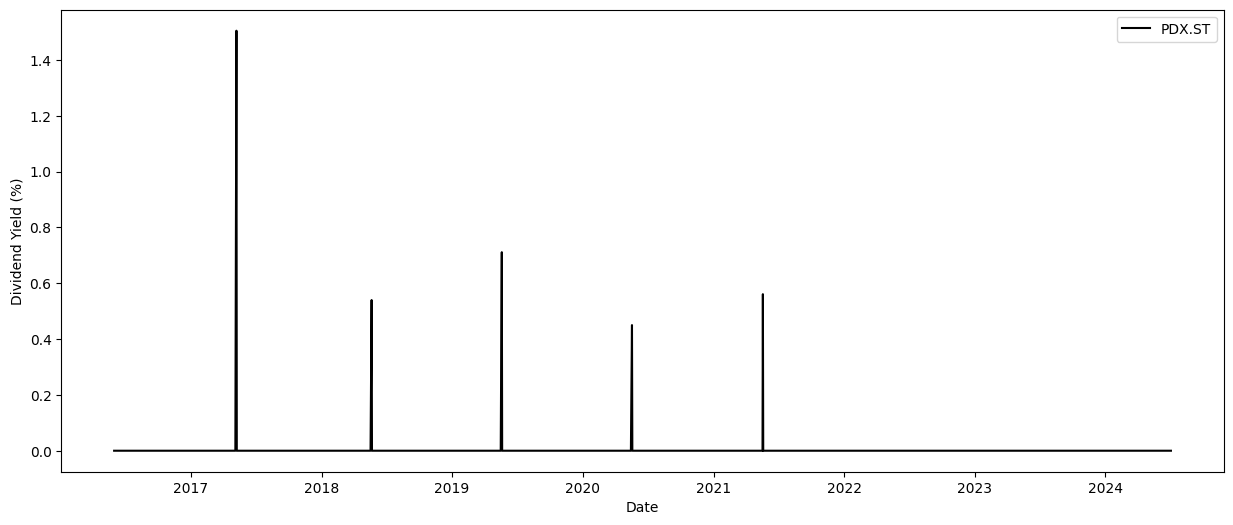

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.464798
share_price      1.000000
Name: share_price, dtype: float64


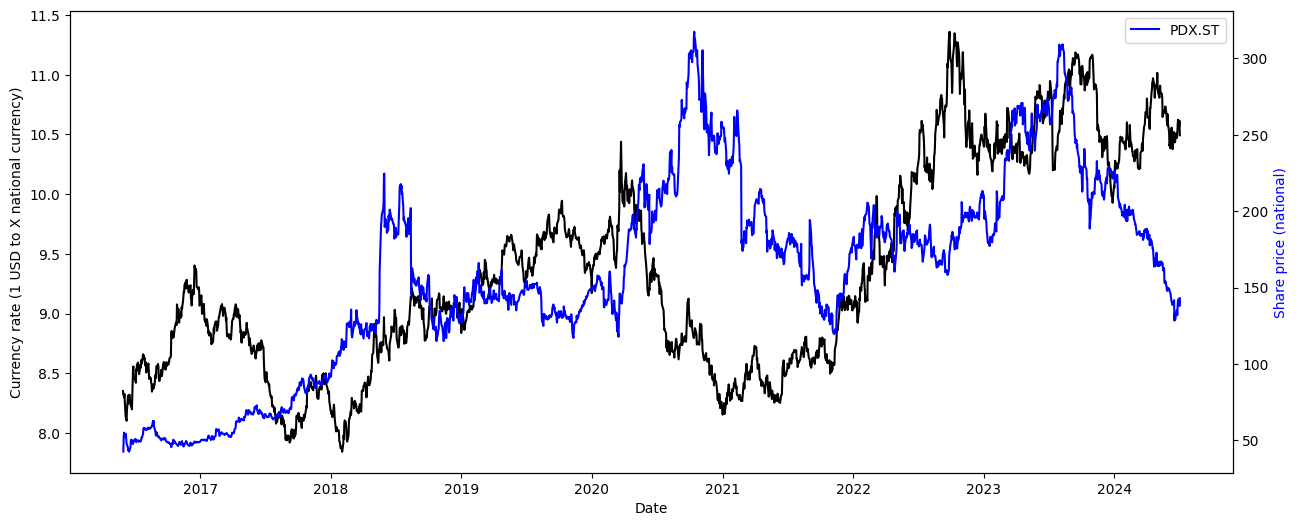

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

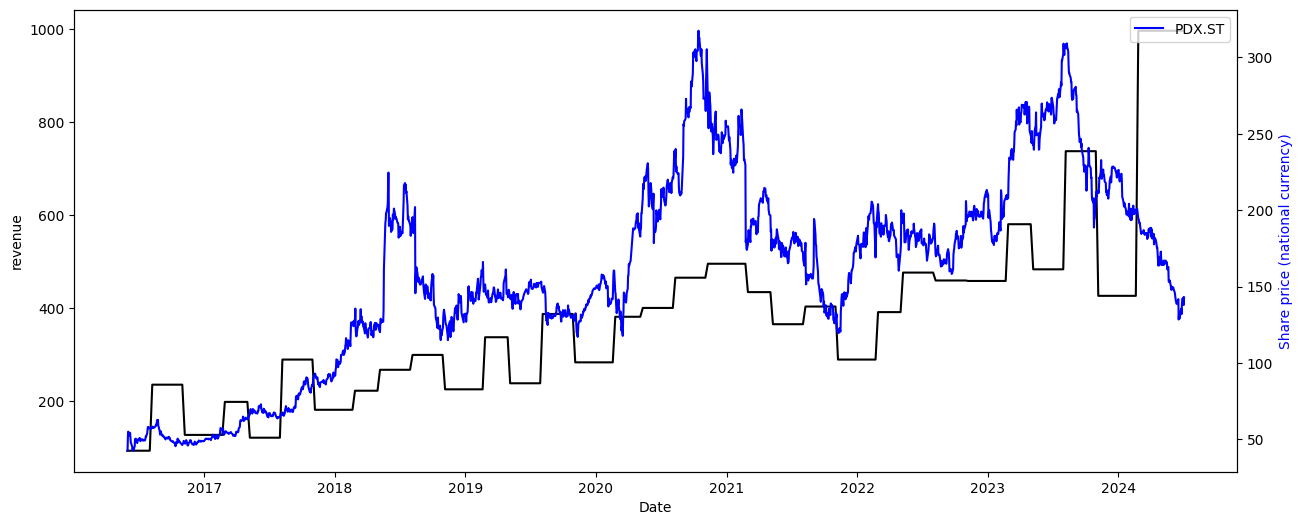

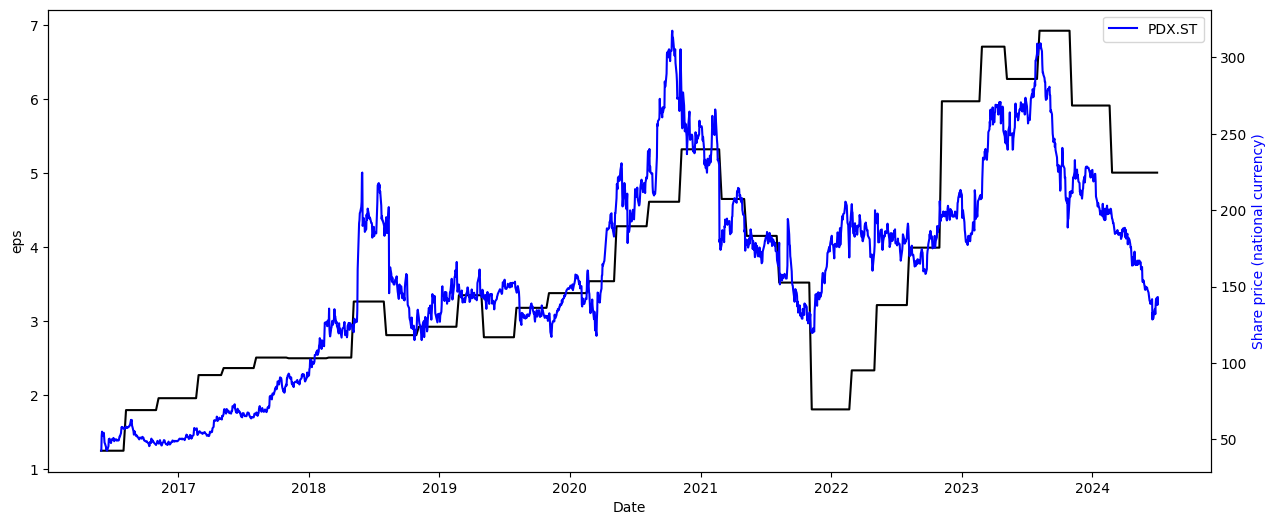

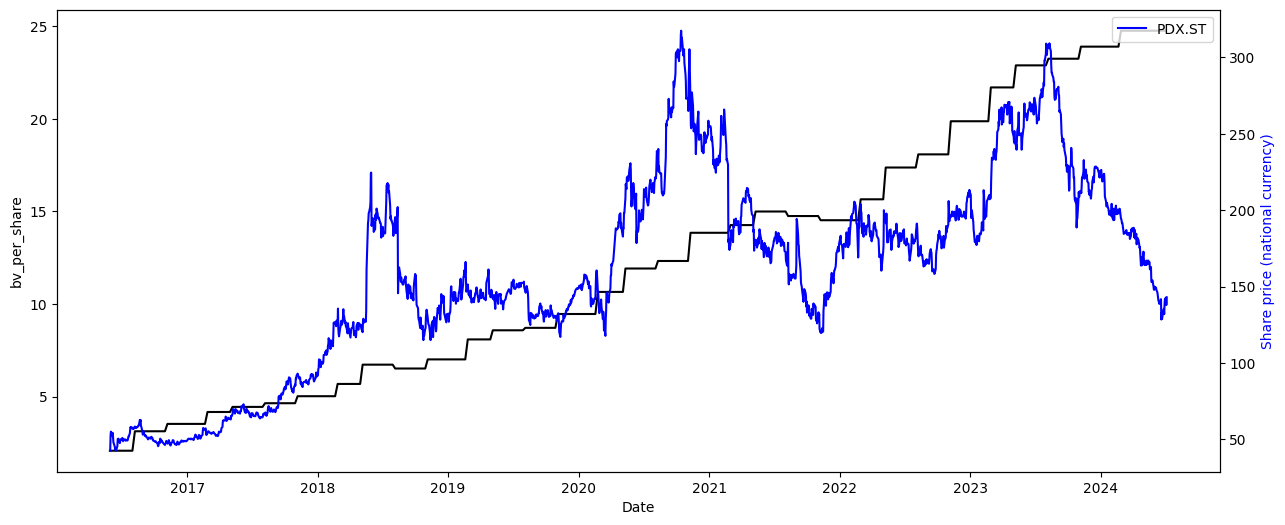

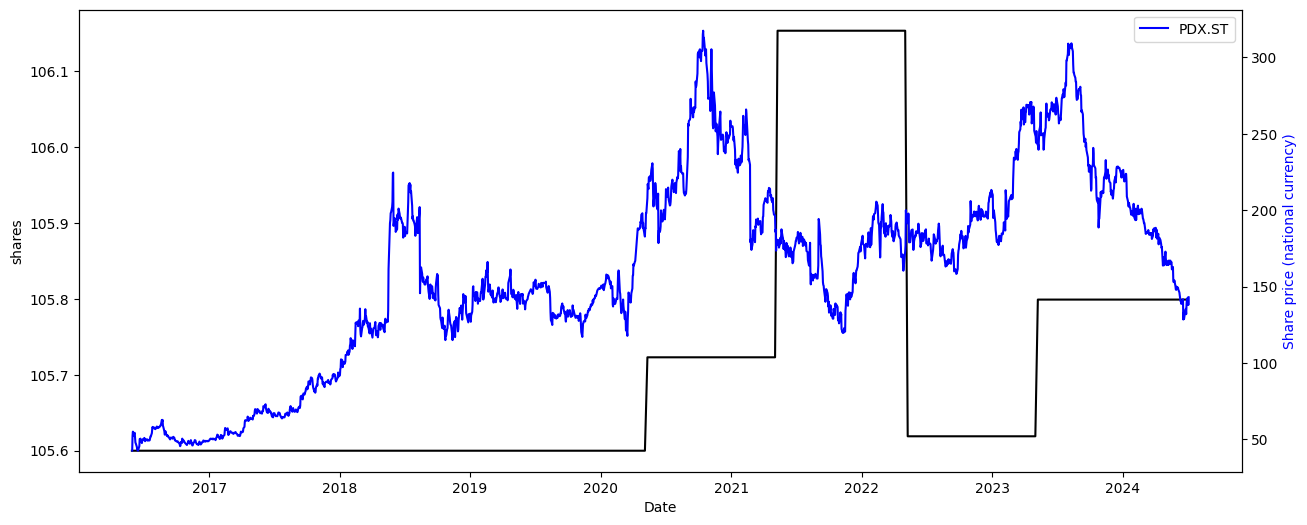

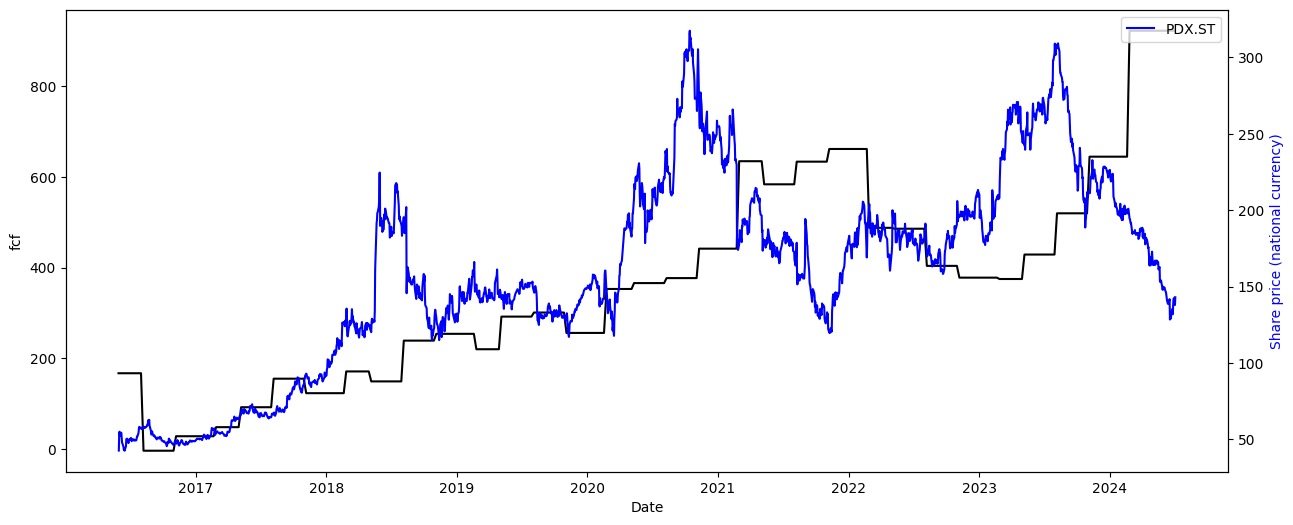

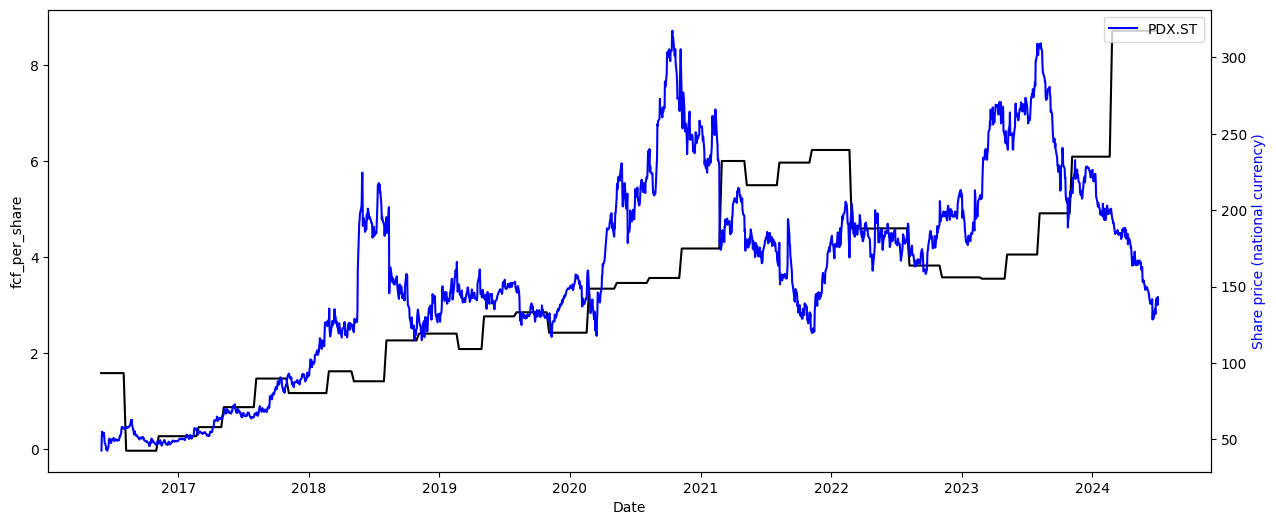

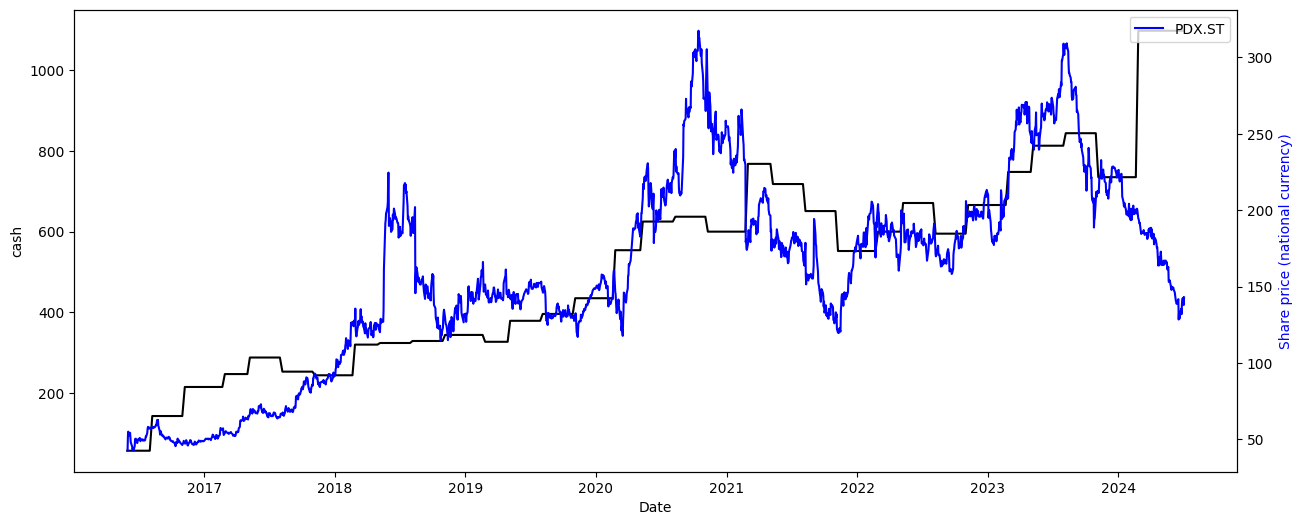

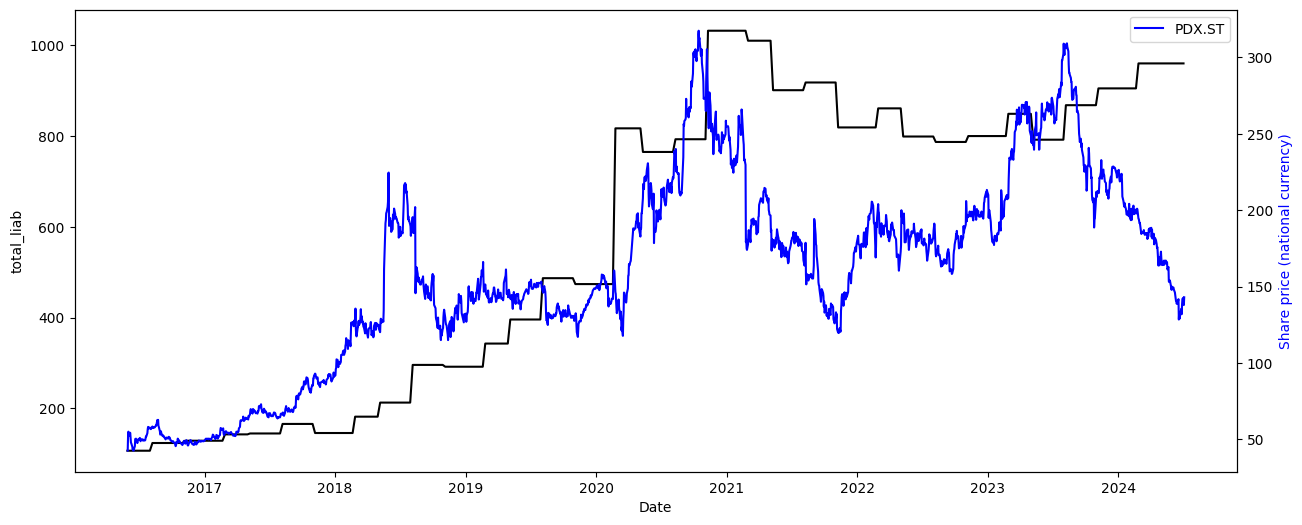

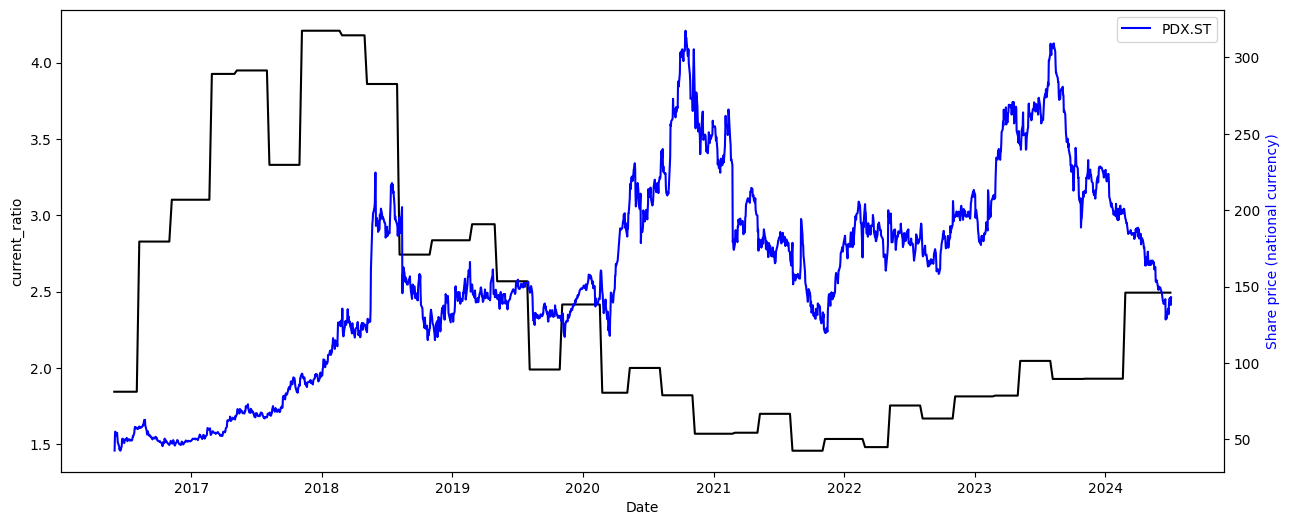

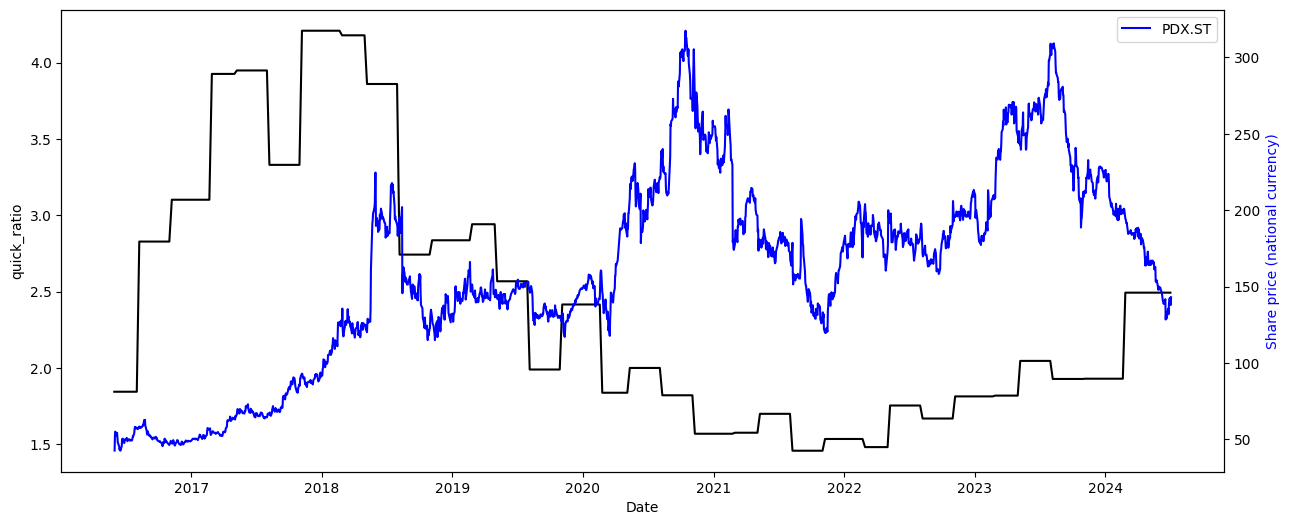

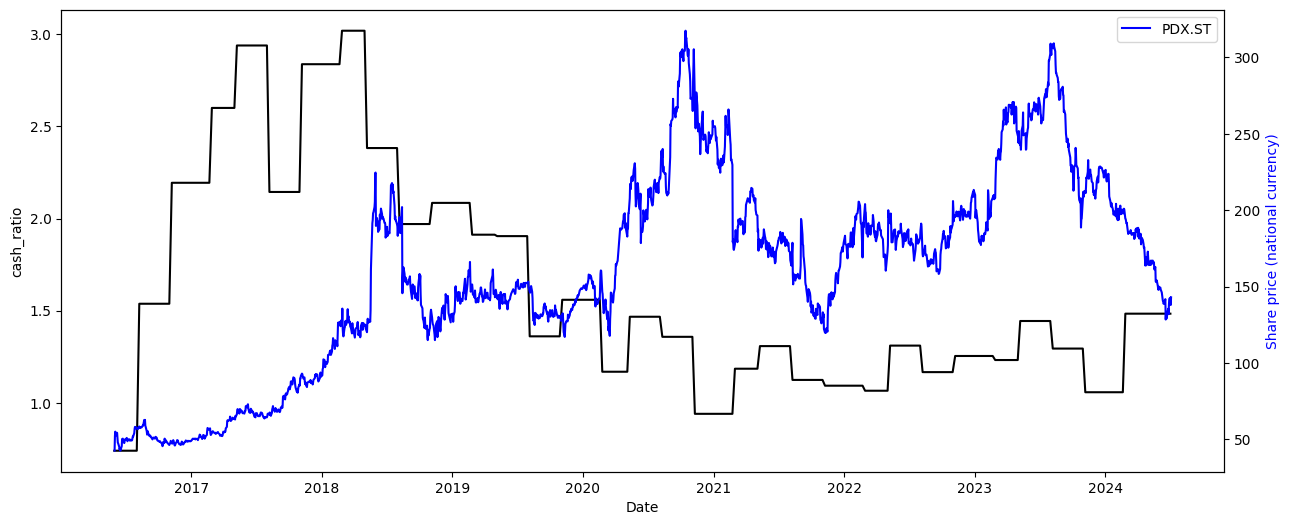

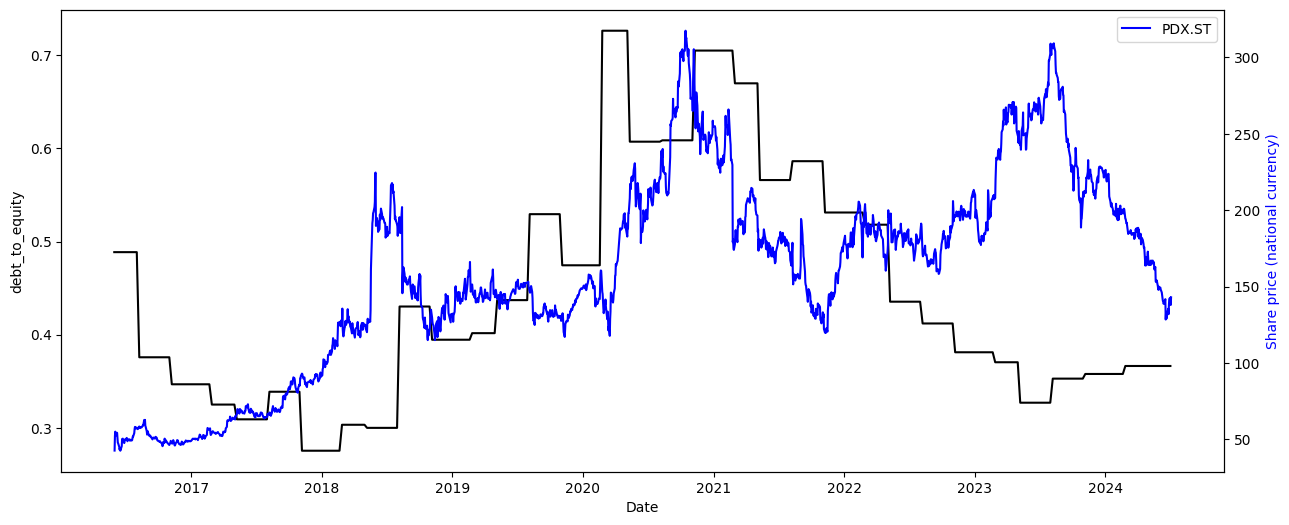

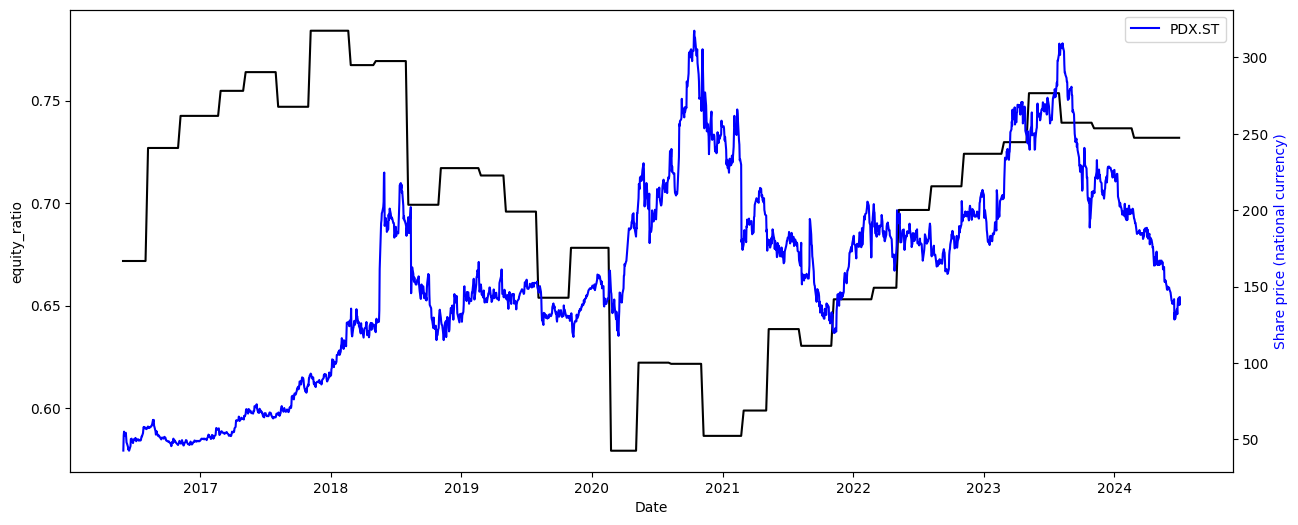

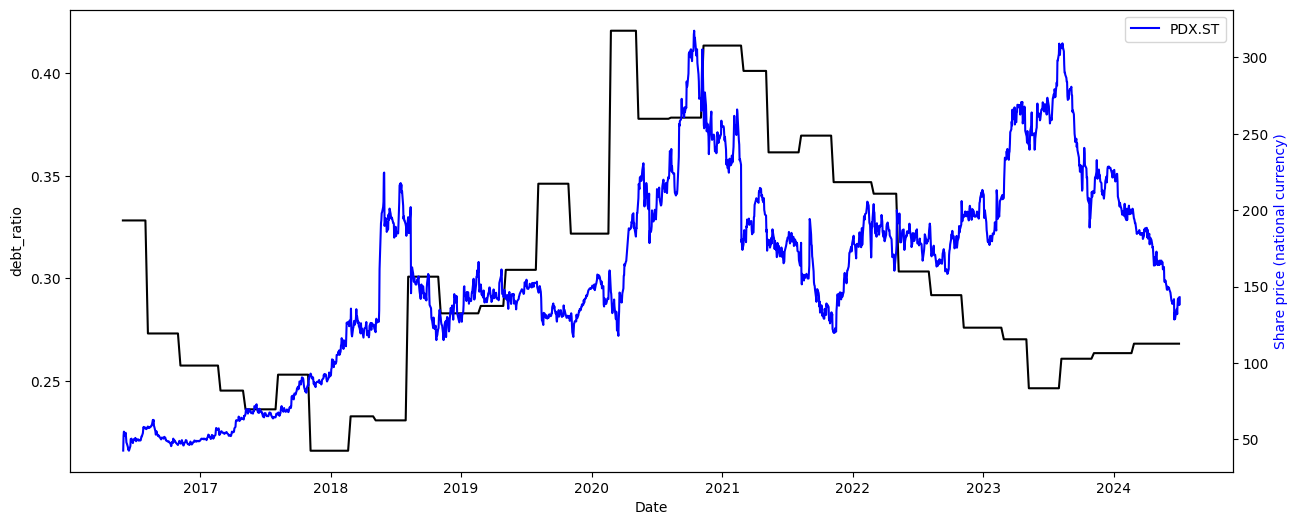

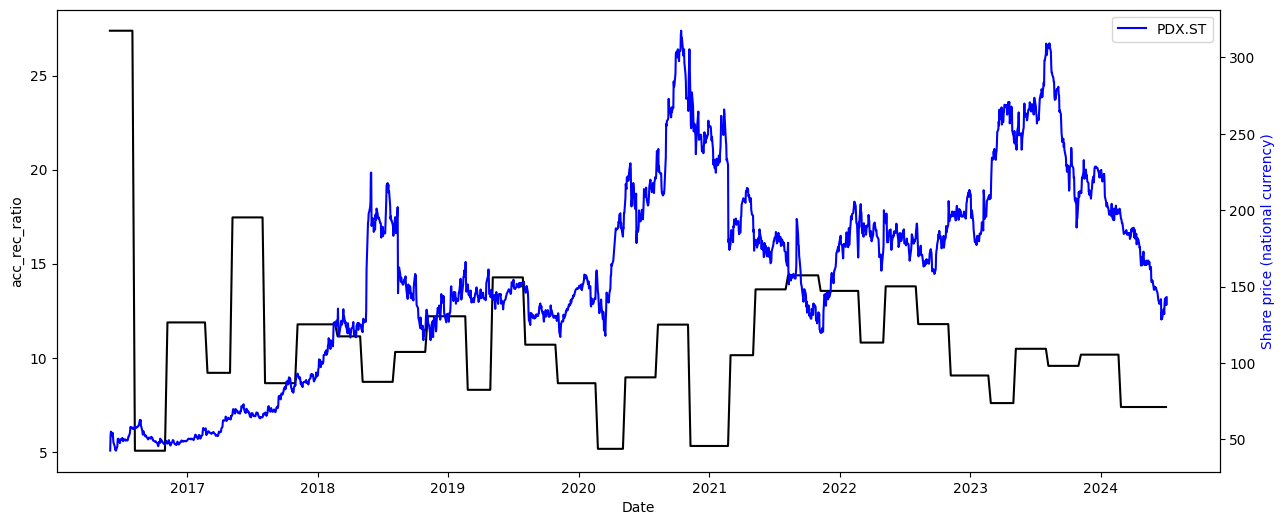

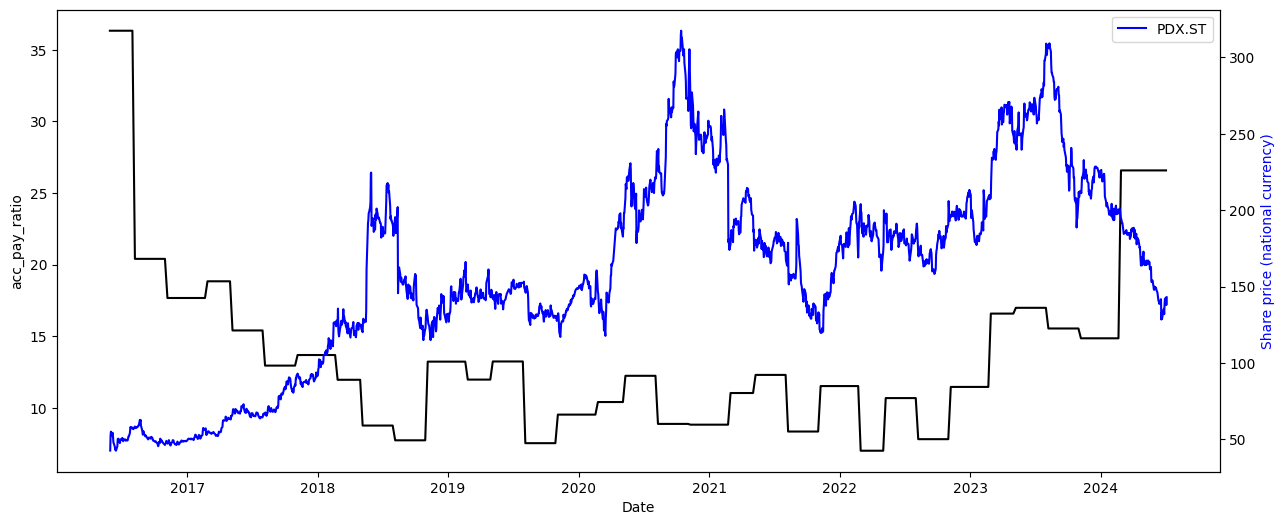

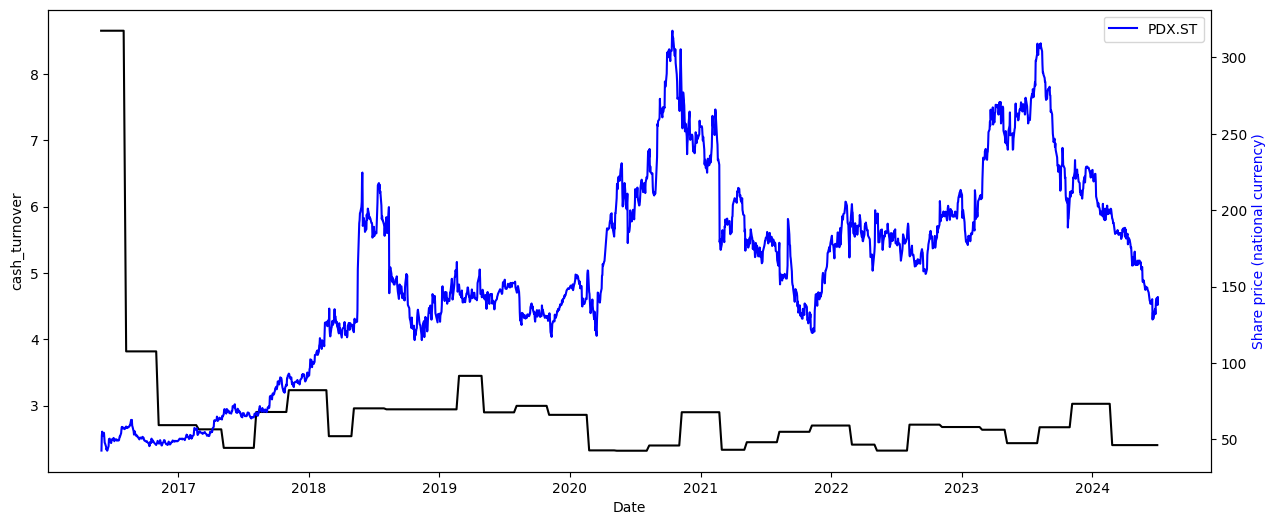

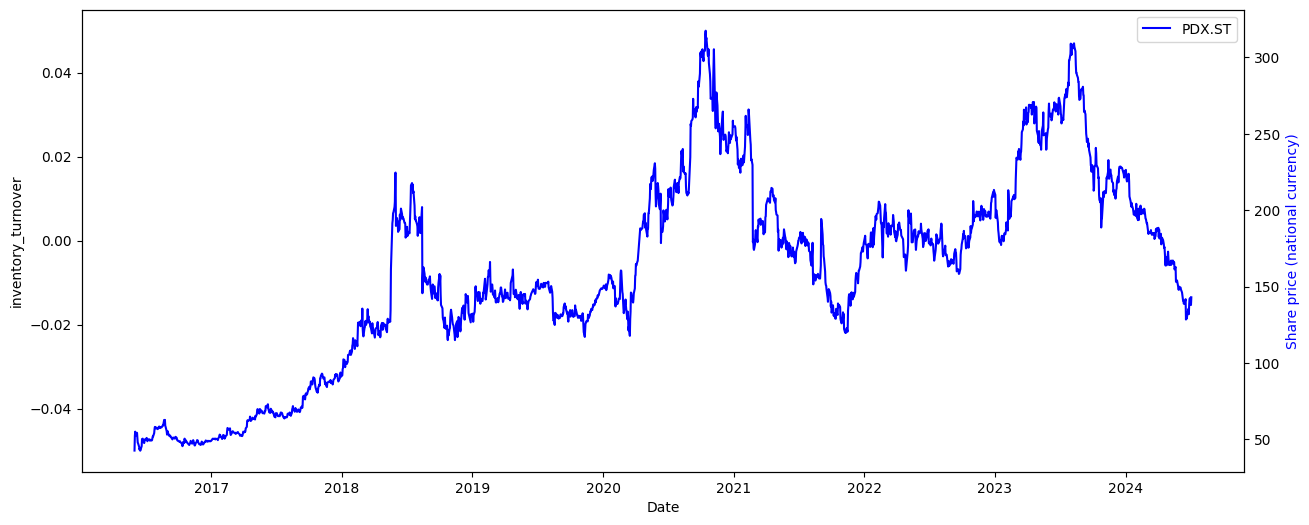

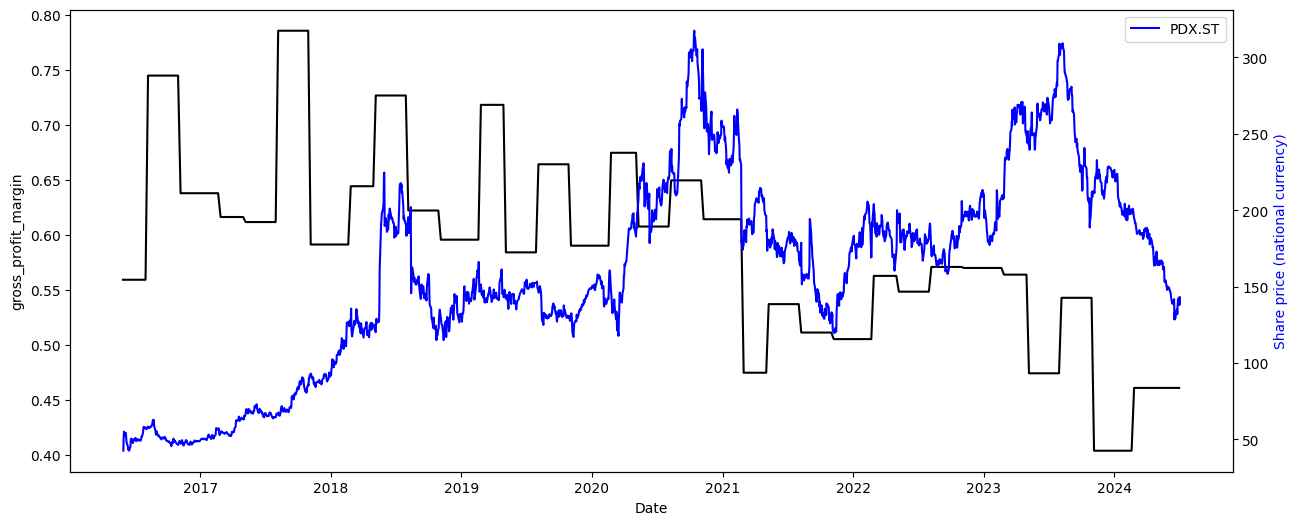

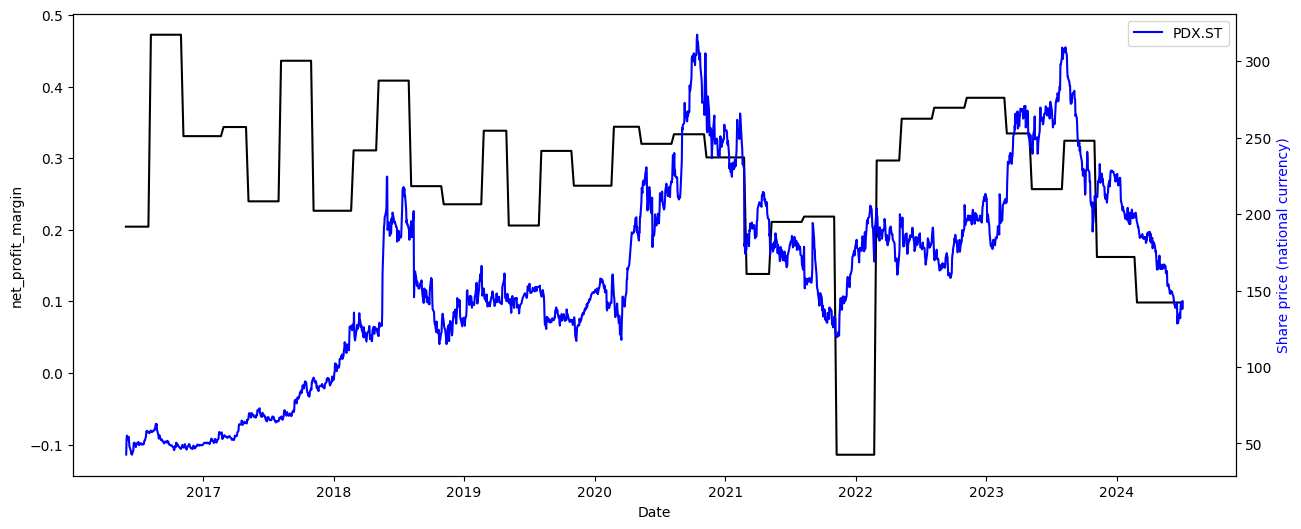

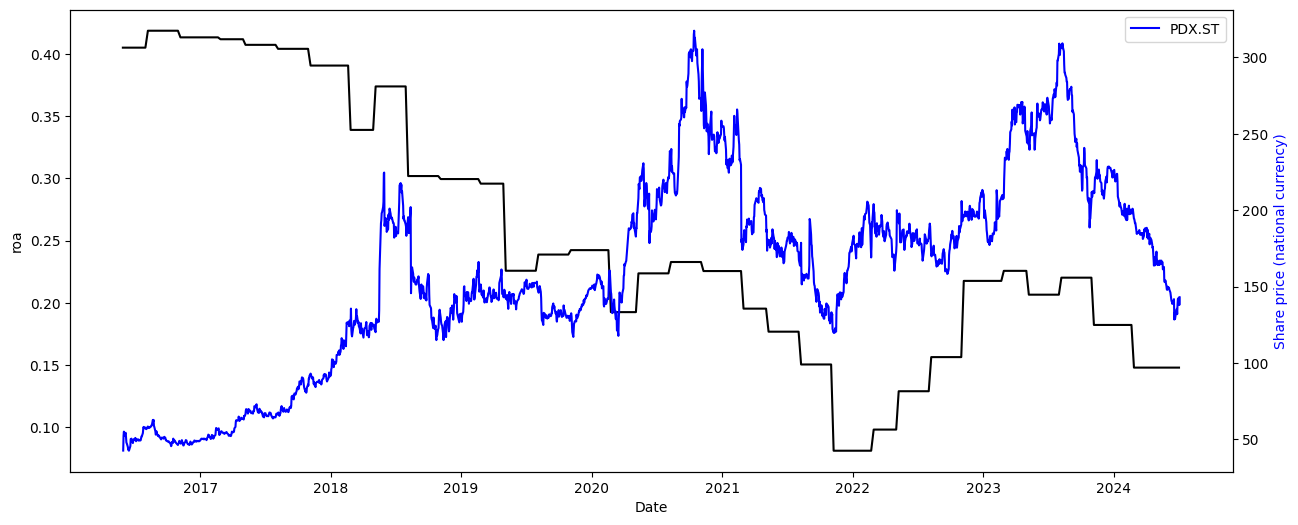

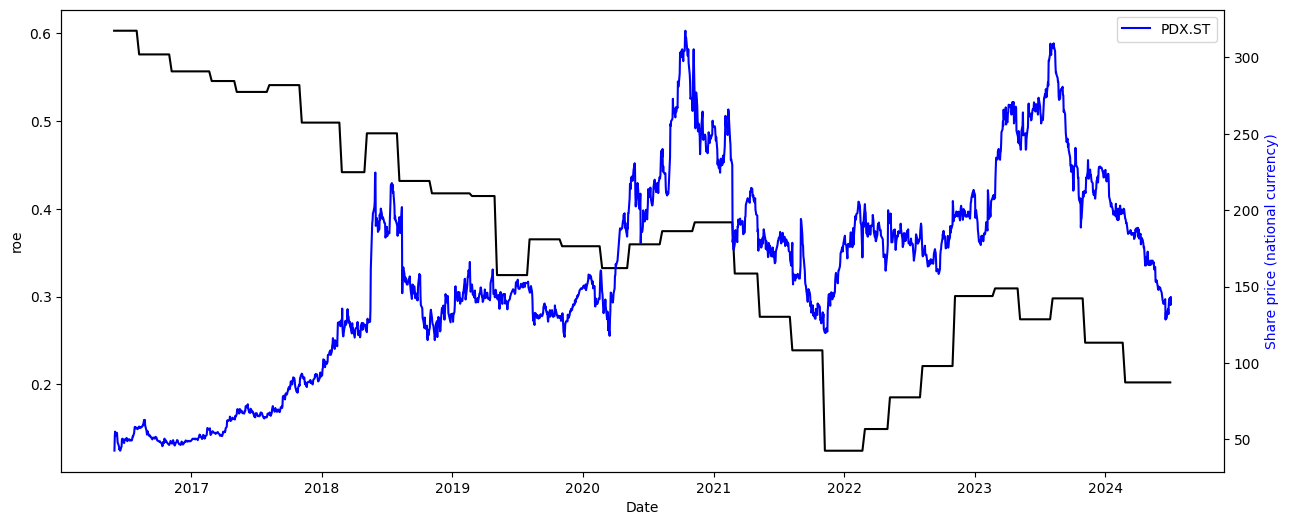

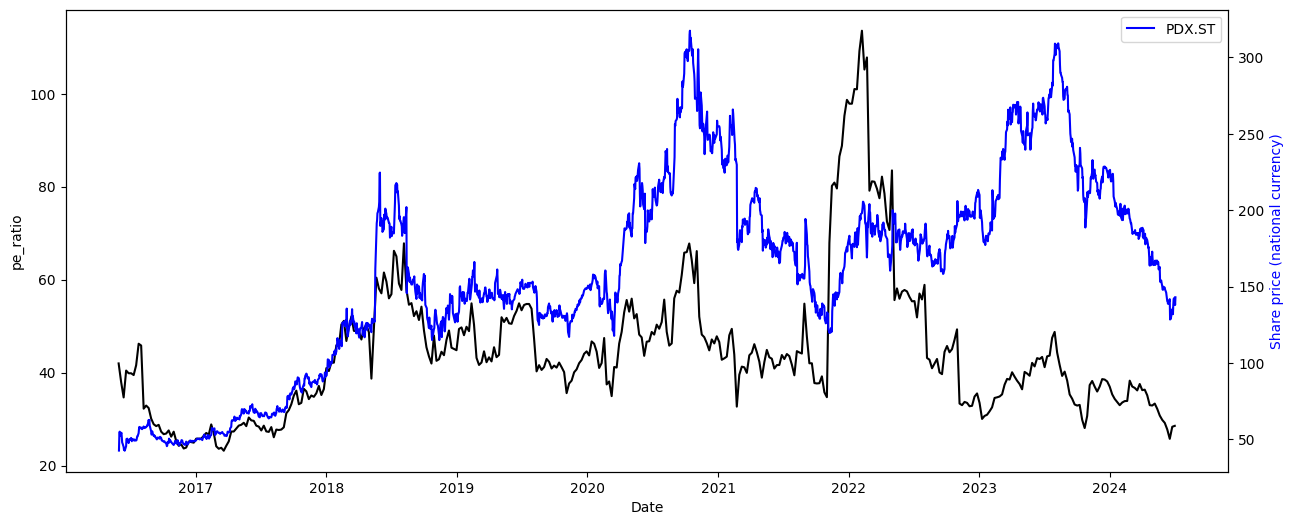

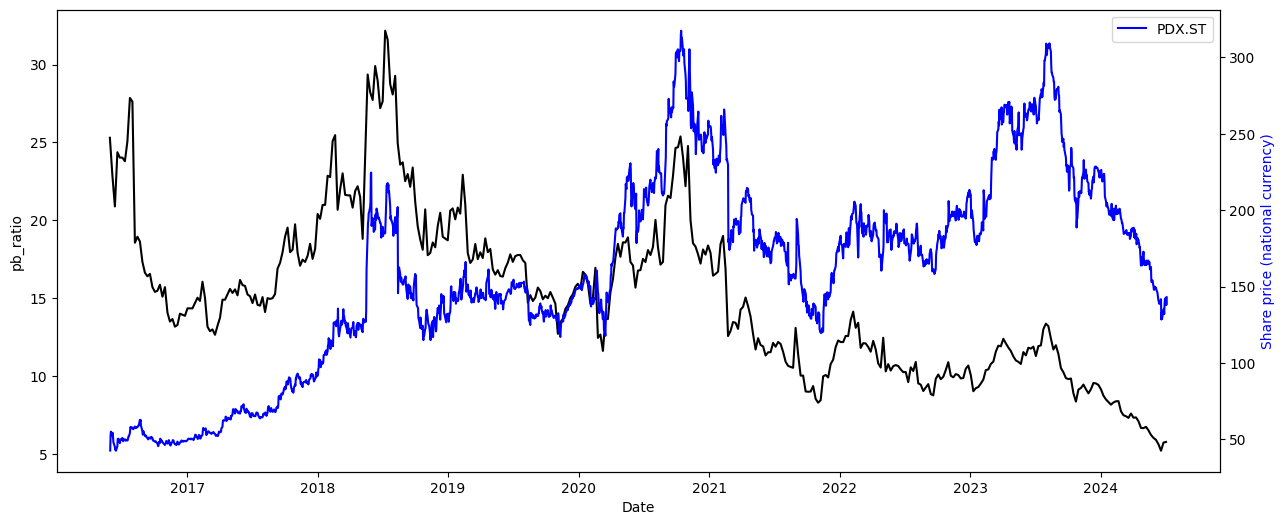

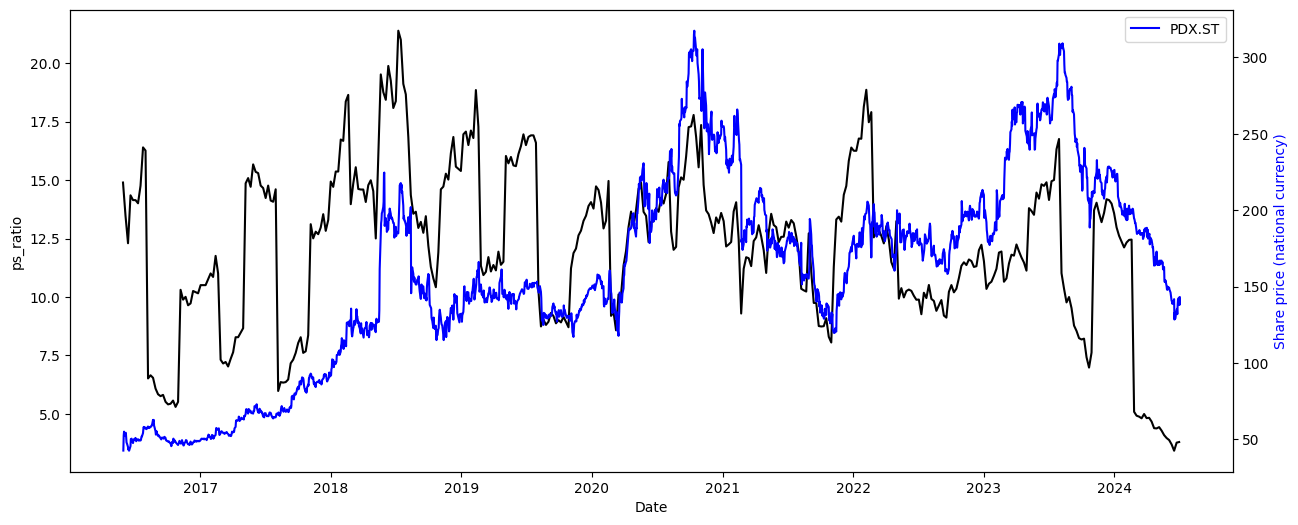

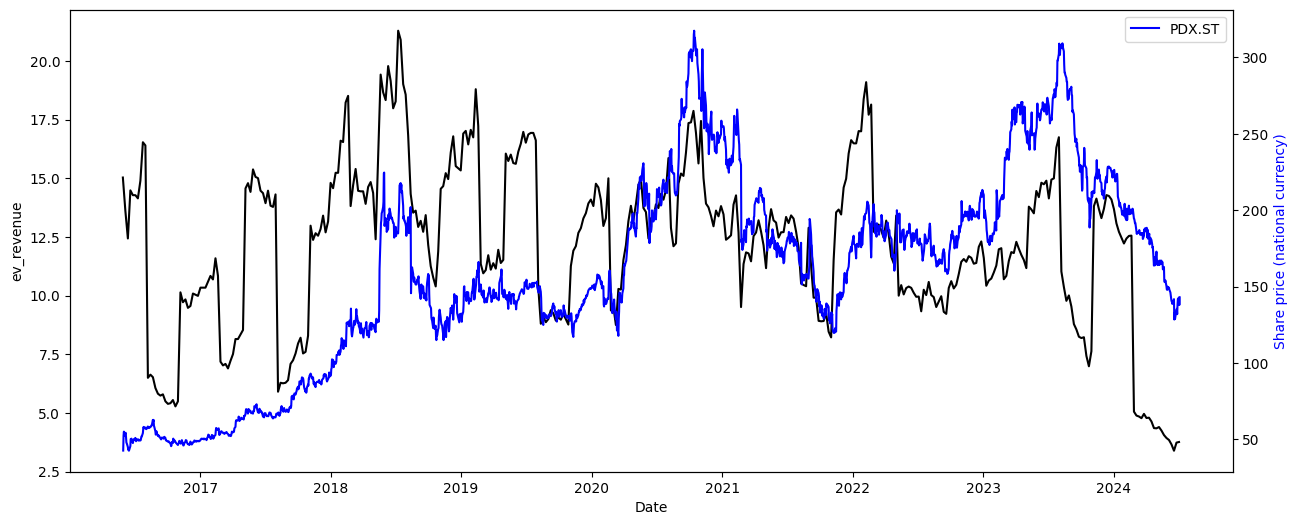

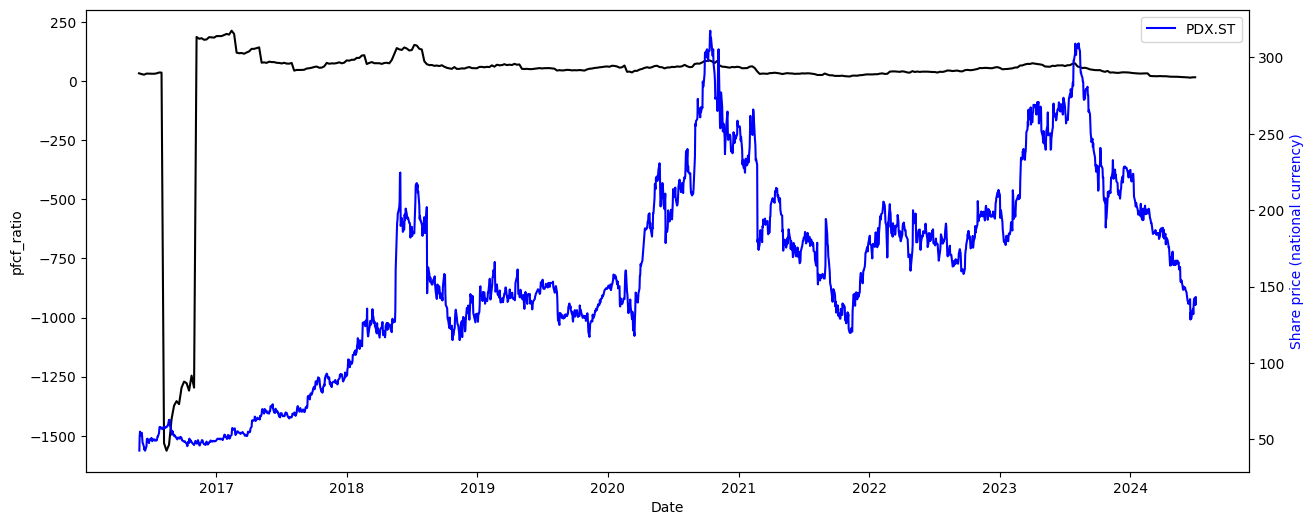

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

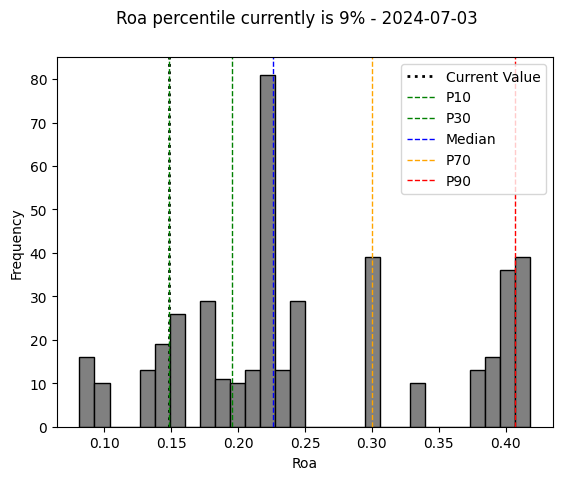

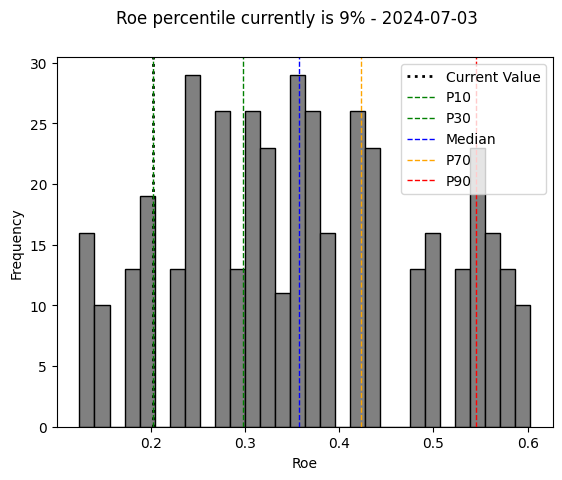

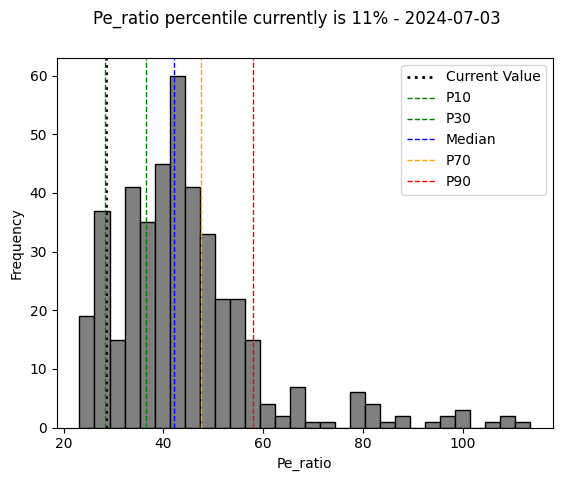

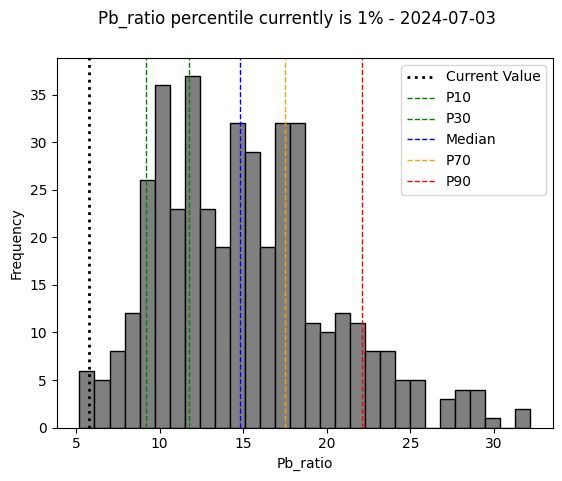

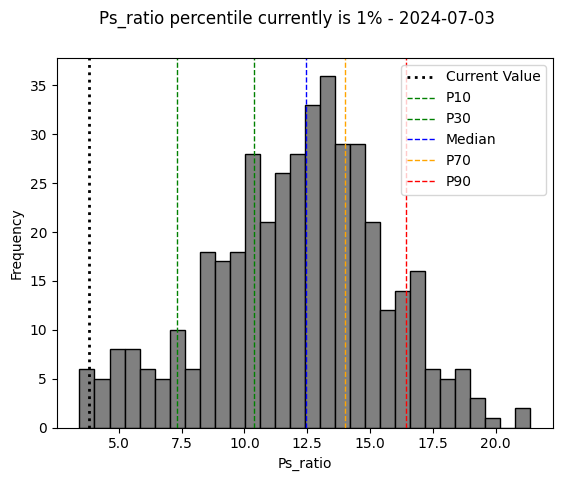

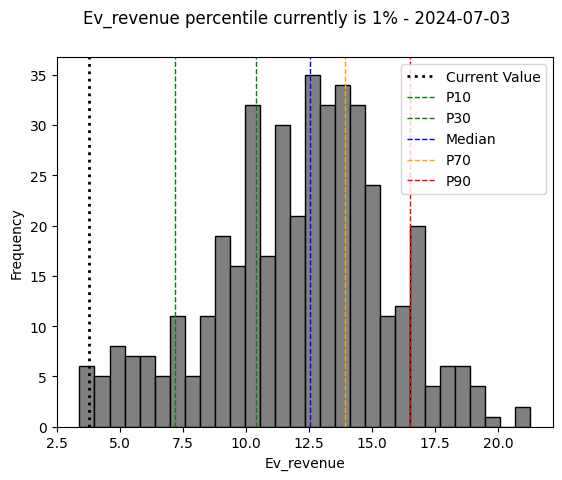

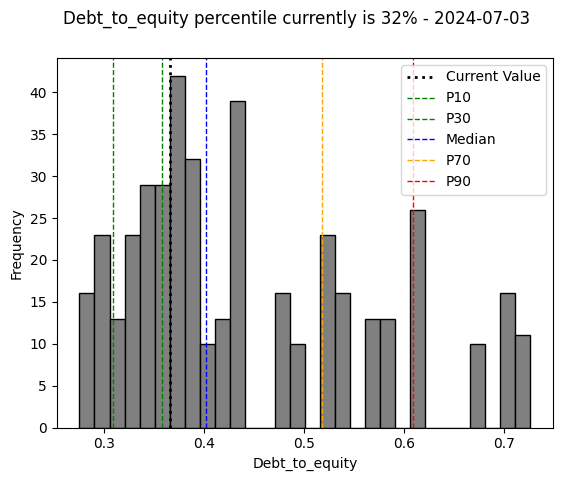

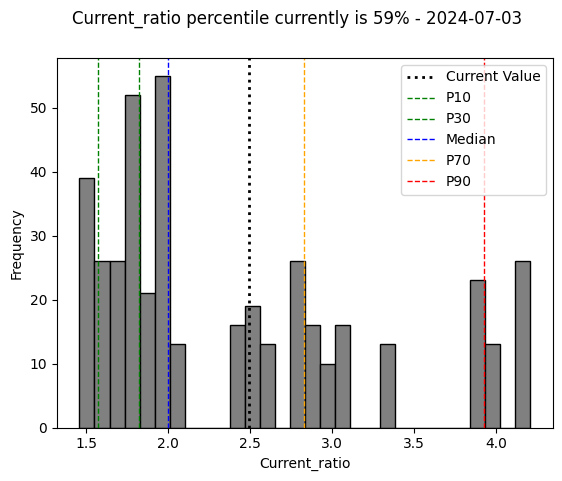

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.979559,-0.503462,0.598483,0.040500,0.014326,-0.489208,0.799528
roe,0.979559,1.000000,-0.489006,0.651092,0.052442,0.030207,-0.312105,0.701361
pe_ratio,-0.503462,-0.489006,1.000000,0.210478,0.550732,0.566900,0.351740,-0.319266
pb_ratio,0.598483,0.651092,0.210478,1.000000,0.594703,0.584534,-0.007136,0.470762
ps_ratio,0.040500,0.052442,0.550732,0.594703,1.000000,0.999388,0.074422,0.098339
ev_revenue,0.014326,0.030207,0.566900,0.584534,0.999388,1.000000,0.101560,0.066849
debt_to_equity,-0.489208,-0.312105,0.351740,-0.007136,0.074422,0.101560,1.000000,-0.685609
current_ratio,0.799528,0.701361,-0.319266,0.470762,0.098339,0.066849,-0.685609,1.000000


19 timestemos have been found!


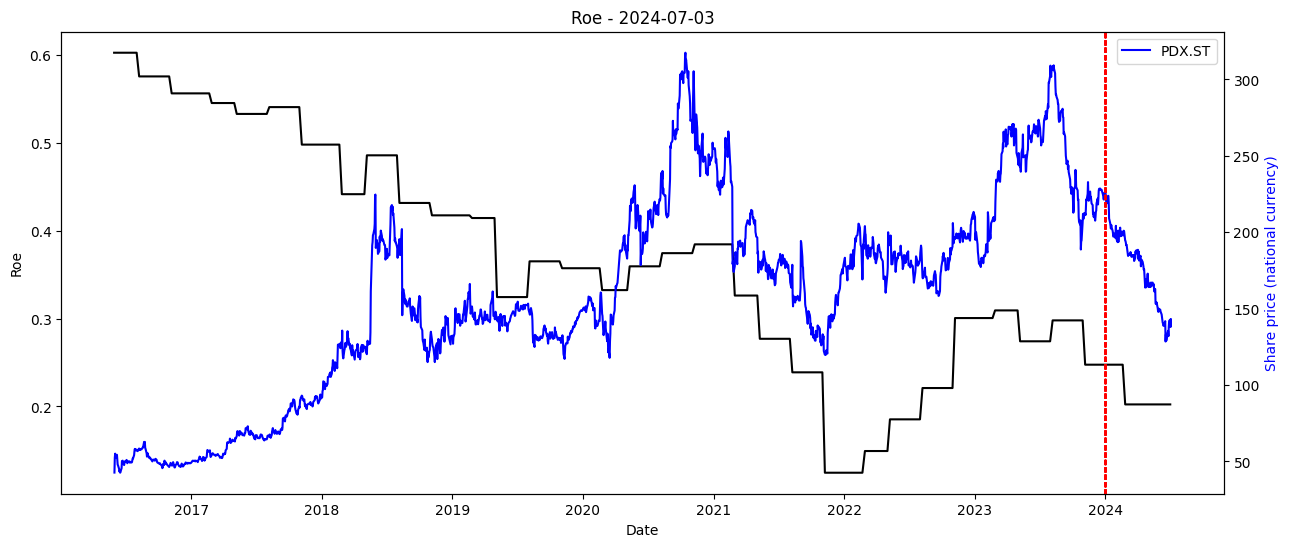

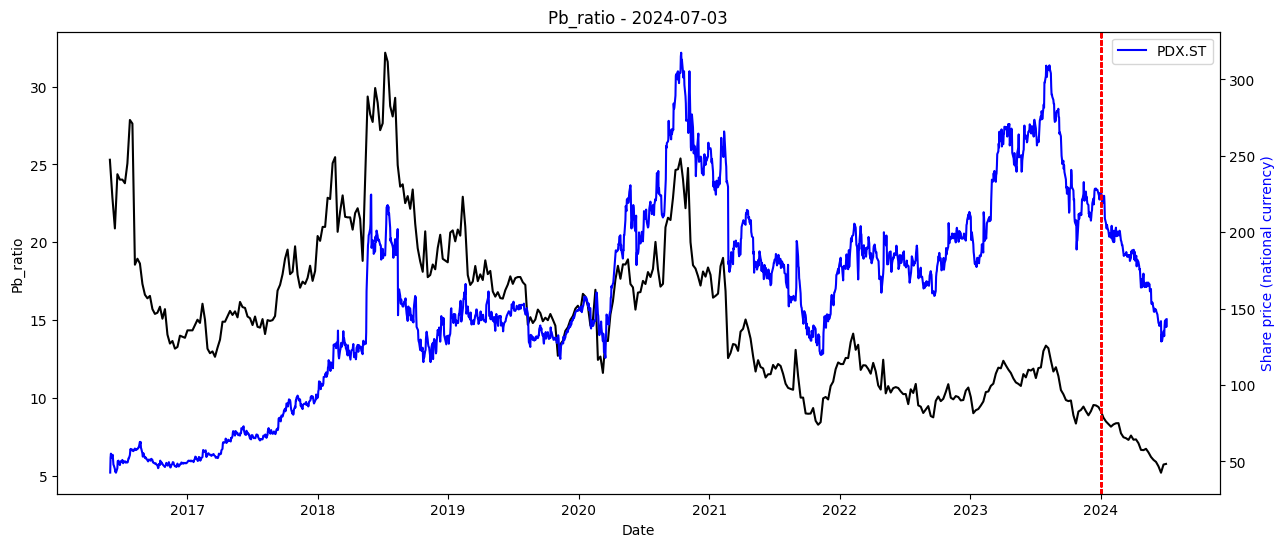

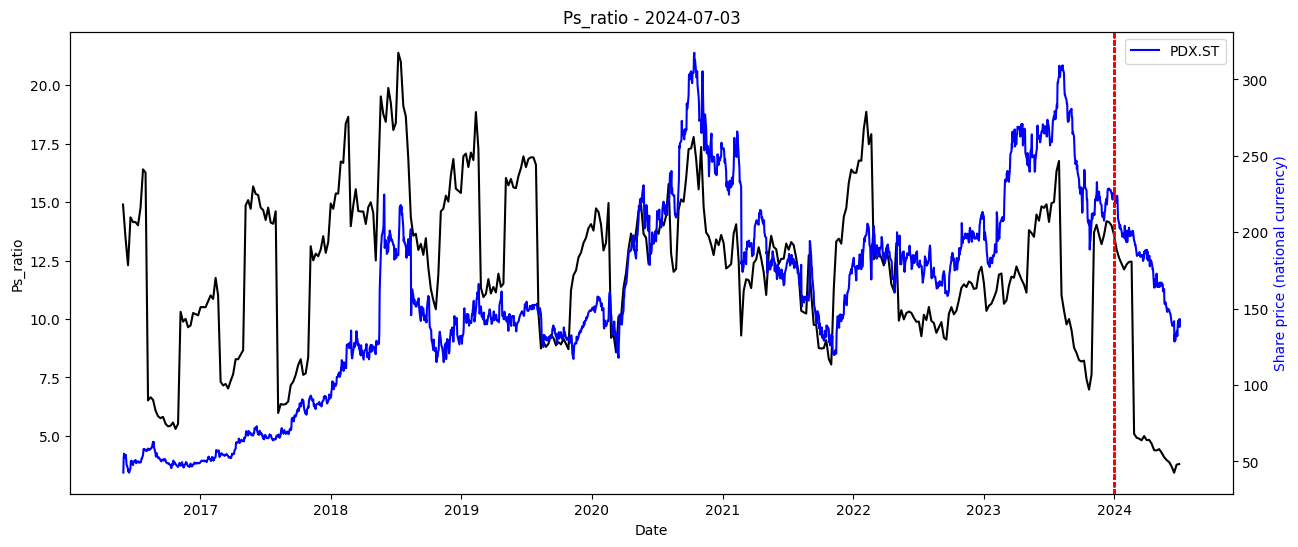

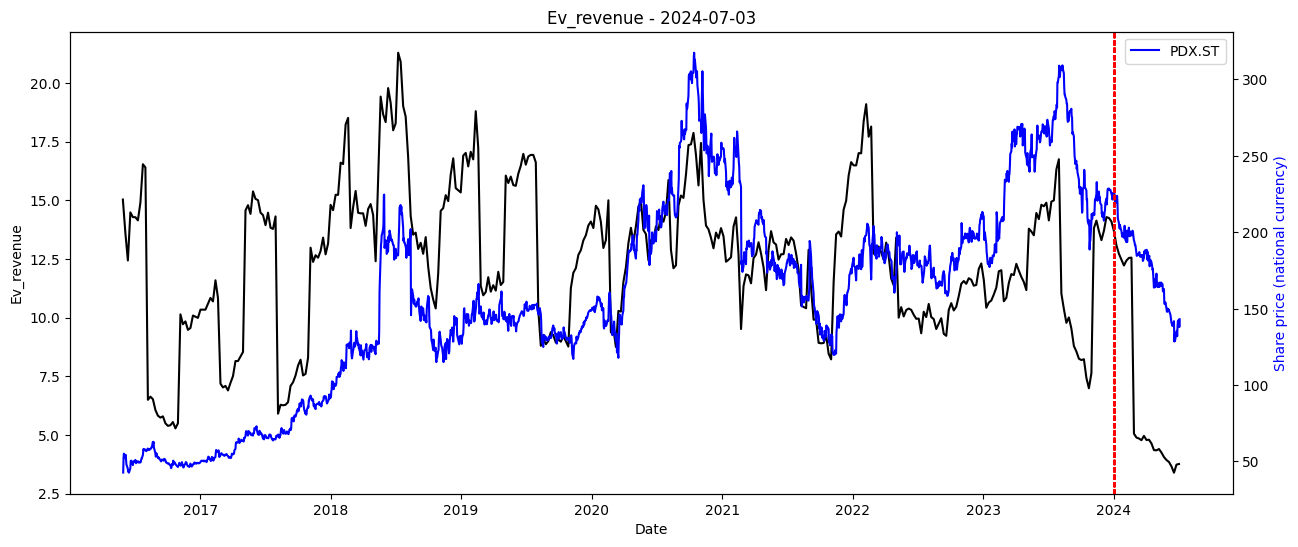

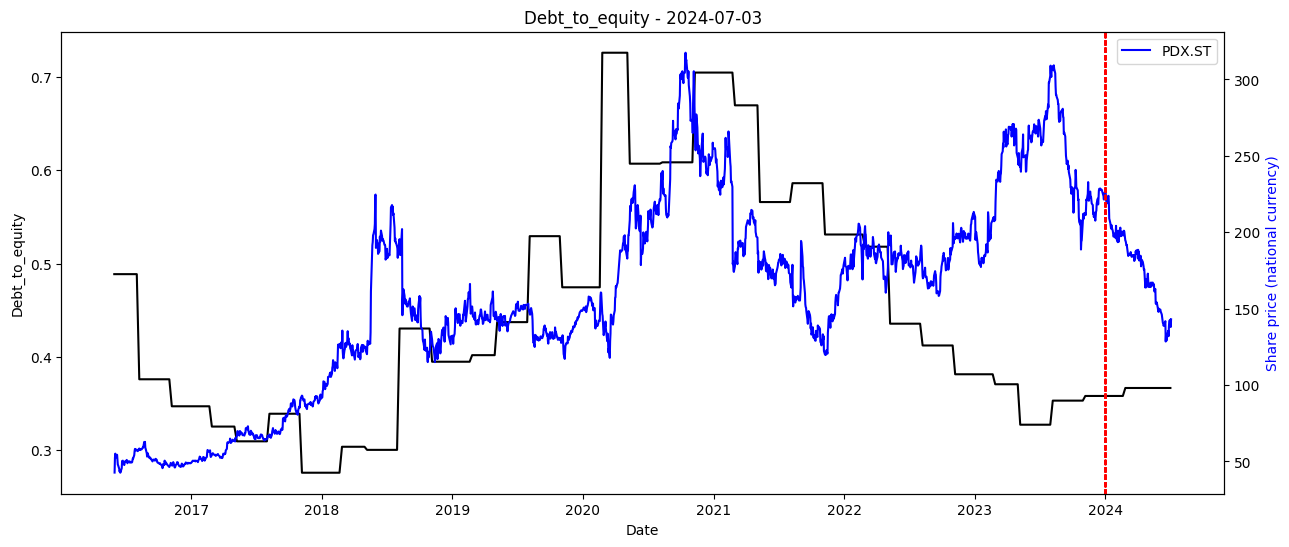

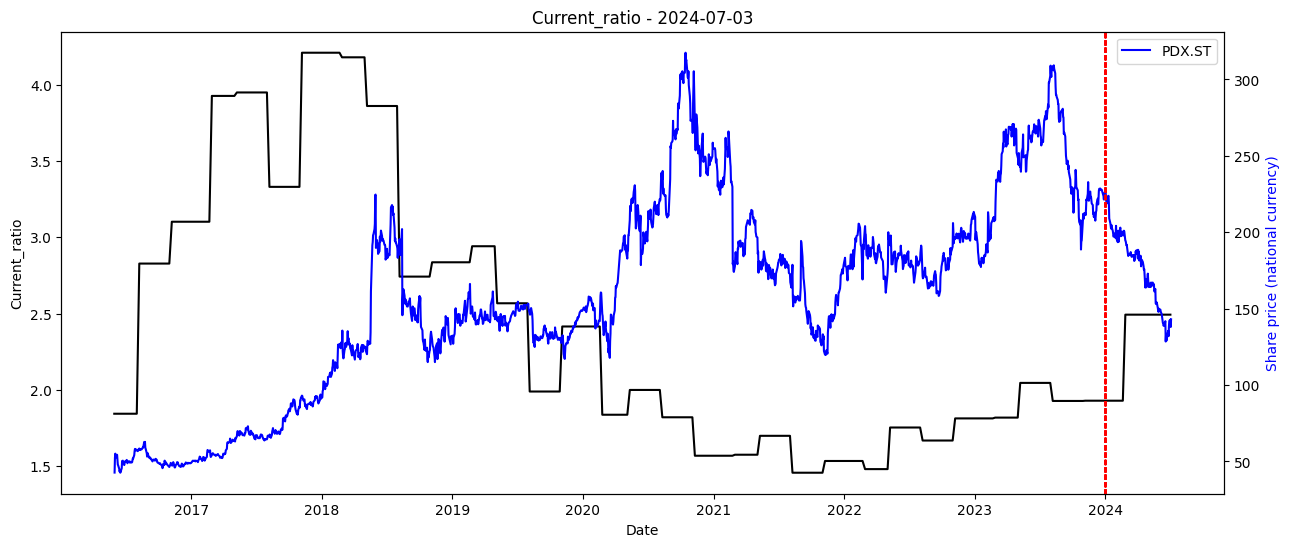

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )